In [17]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

In [6]:
from src.utils.general import get_db_conn, get_boto3_session, load_model_s3, load_matrix_s3
from src.utils import project_constants as constants

# from src.bill_passage.model_analysis_functions import fetch_evaluations_models, fetch_all_evaluations_for_model

In [7]:
cred_file = '../conf/local/credentials.yaml'
db_conn=get_db_conn(cred_file)
s3_session = get_boto3_session(cred_file)

# experiment_hash = '6c185dd4b5d63791b315c5412b6144a9'
project_path = 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_long_term_master_final'

In [15]:
# experiment_hash=exps['experiment_hash'].at[2]
# q = """
#     with models as (
#         select 
#             model_id, model_hash, model_group_id, model_type, hyperparameters, to_char(train_end_time, 'YYYY-MM-DD') as train_end_time,  train_matrix_uuid
#         from triage_metadata.experiment_models join triage_metadata.models using(model_hash)
#         where experiment_hash='{}'
#         order by train_end_time
#     )
#     select 
#         model_id, model_hash, model_group_id, model_type, hyperparameters, train_end_time,  train_matrix_uuid, matrix_uuid as test_matrix_uuid
#     from models join test_results.prediction_metadata using(model_id)
    
# """.format(experiment_hash)

# models = pd.read_sql(q, db_conn)
# models

#### Crosstabs config

In [18]:
config_file = '../src/bill_passage/postmodeling/crosstabs_config.yaml'
with open(config_file) as f:
    config = yaml.safe_load(f)
config

{'output': {'schema': 'test_results', 'table': 'crosstabs'},
 'thresholds': {'rank_abs': [100],
  'rank_pct': [10],
  'score_bins': {'will_not_pass': [0, 0.1],
   'unlikely': [0.1, 0.35],
   'coin-toss': [0.35, 0.55],
   'likely': [0.55, 0.7],
   'very_likely': [0.7, 0.9],
   'will_pass': [0.9, 1.0]}},
 'model_ids': [16465, 16592, 16722, 16850],
 'project_path': 's3://aclu-leg-tracker/experiment_data/bill_passage/triage/national_lt'}

### Analysing a single model

In [21]:
# idx = 12
# model_id = models.at[idx, 'model_id']
# train_end_time = models.at[idx, 'train_end_time']
model_id = config['model_ids'][1]

q = """
    select 
        * 
    from triage_metadata.models
    where model_id = {}
""".format(model_id)

model_info = pd.read_sql(q, db_conn)
train_end_time = model_info.at[0, 'train_end_time']

In [9]:
q = """
    select 
        model_id,
        metric,
        parameter,
        split_part("parameter", '_', 1)::int as param_threshold,
        num_labeled_above_threshold,
        stochastic_value as value
    from test_results.evaluations
    where metric!='roc_auc'
    and model_id={}
""".format(model_id)

model_evaluations = pd.read_sql(q, db_conn)
# model_evaluations

**PR-Curve**

Text(0.5, 1.0, 'PR-Curve for Model ID: 16592, train_end_time 2018-06-01 00:00:00')

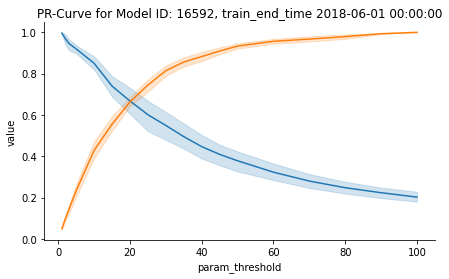

In [22]:
msk1 = model_evaluations['parameter'].str.contains('pct')
msk_prec = model_evaluations['metric'].str.contains('precision')
msk_recall = model_evaluations['metric'].str.contains('recall')

fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(data=model_evaluations[msk1 & msk_prec].sort_values('param_threshold'), x='param_threshold', y='value')
sns.lineplot(data=model_evaluations[msk1 & msk_recall].sort_values('param_threshold'), x='param_threshold', y='value')
sns.despine()
ax.set_title('PR-Curve for Model ID: {}, train_end_time {}'.format(model_id, train_end_time))

**Absolute List sizes**

In [23]:
msk1 = model_evaluations['parameter'].str.contains('abs')
msk_prec = model_evaluations['metric'].str.contains('precision')
msk_recall = model_evaluations['metric'].str.contains('recall')

In [24]:
# sns.lineplot(data=model_evaluations[msk1 & msk_prec].sort_values('param_threshold'), x='param_threshold', y='value')
# sns.lineplot(data=model_evaluations[msk1 & msk_recall].sort_values('param_threshold'), x='param_threshold', y='value')

**Predictions -- Score Distribution**

In [25]:
q = """
    select 
        entity_id, to_char(as_of_date, 'YYYY-MM-DD') as as_of_date, score, label_value, rank_abs_no_ties, rank_abs_with_ties, rank_pct_no_ties, rank_pct_with_ties
    from test_results.predictions where model_id={}
    order by score desc
""".format(model_id)

model_predictions = pd.read_sql(q, db_conn)
model_predictions.head()

,entity_id,as_of_date,score,label_value,rank_abs_no_ties,rank_abs_with_ties,rank_pct_no_ties,rank_pct_with_ties
0,1122225,2018-06-15,0.99085,1,1,1,0.00001,0.00002
1,1122231,2018-06-15,0.98893,1,2,2,0.00003,0.00003
2,1122213,2018-06-15,0.98769,1,3,3,0.00004,0.00005
3,1122251,2018-06-15,0.98732,1,4,4,0.00006,0.00006
4,1122264,2018-06-15,0.98682,1,5,5,0.00007,0.00008


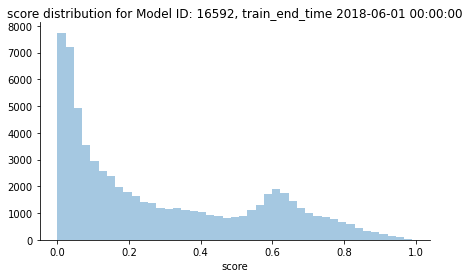

In [26]:
fig, ax = plt.subplots(figsize=(7,4))
sns.distplot(model_predictions['score'], kde=False)
ax.set_title('score distribution for Model ID: {}, train_end_time {}'.format(model_id, train_end_time))
sns.despine()

#### Analysing Features (Model level)

In [27]:
q = """ select feature, feature_importance, rank_abs, rank_pct from train_results.feature_importances where model_id={} order by rank_abs """.format(model_id)

feature_importance = pd.read_sql(q, db_conn)

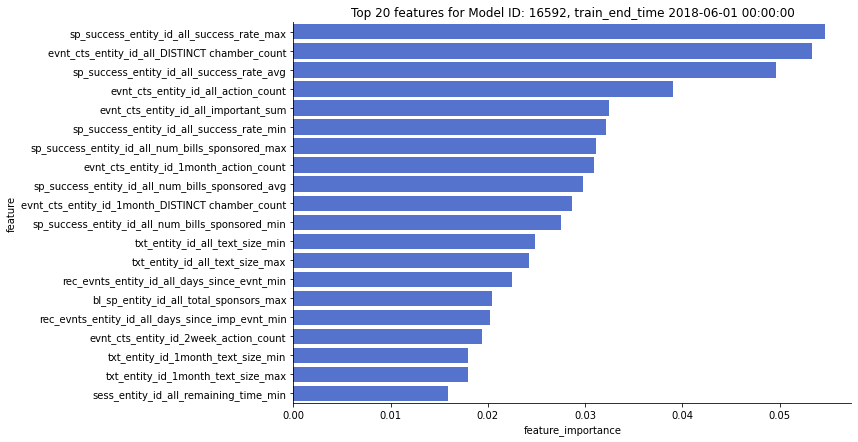

In [28]:
fig, ax = plt.subplots(figsize=(10,7))
n_features_to_plot = 20
sns.barplot(data=feature_importance.iloc[:n_features_to_plot], x='feature_importance', y='feature', color='royalblue')
ax.set_title('Top 20 features for Model ID: {}, train_end_time {}'.format(model_id, train_end_time))
sns.despine()

**Relevant Feature inspection**

In [31]:
outcome_col='lt_passed'

In [32]:
mat_uuid = models.at[idx, 'test_matrix_uuid']
mat_path = '{}/matrices/{}.csv.gz'.format(project_path, mat_uuid)

test_matrix = load_matrix_s3(s3_session, mat_path, compression='gzip').reset_index()

In [33]:
## Joining with predictions
test_matrix = test_matrix.merge(model_predictions, on=['entity_id', 'as_of_date'])

**Score Buckets**

In [34]:
buckets = {
    'will_not_pass': [0, 0.10],
    'unlikely': [0.10, 0.35],
    'could go either way': [0.35, 0.55],
    'likely': [0.55, 0.70],
    'very_likely': [0.70, 0.90],
    'will_pass': [0.90, 1.1]
}

def assign_bucket(row, buckets):
    for bucket, lims in buckets.items():
        if row['score'] >= lims[0] and row['score'] < lims[1]:
            row['likelihood_bin'] = bucket
            break
    return row

test_matrix = test_matrix.apply(assign_bucket, buckets=buckets, axis=1)

In [35]:
label_msk = test_matrix[outcome_col]==1

In [64]:
feature_name = 'event_counts_entity_id_all_action_count'

In [65]:
# # fig, ax = plt.subplots(figsize=(6,4))
# g = sns.FacetGrid(test_matrix, col=outcome_col, height=4, aspect=1.2)
# g.map(sns.distplot, feature_name, kde=False)
# # plt.title('Distribution of {} w.r.t the label'.format(feature_name))

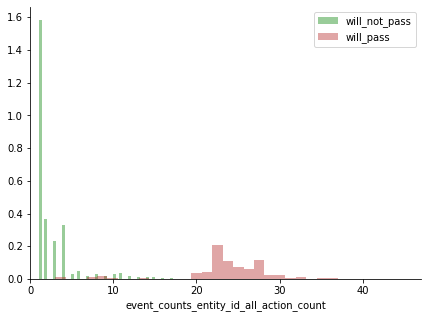

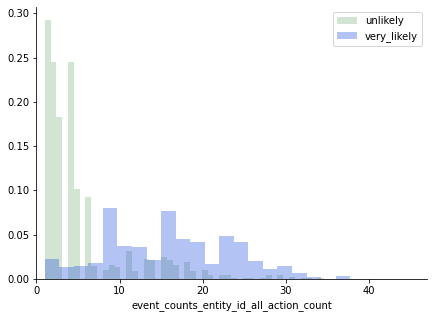

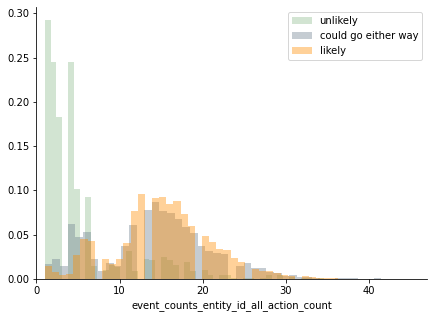

In [ ]:
bin_subsets = {
    'extremes': ['will_not_pass', 'will_pass'],
    'second_level': ['unlikely', 'very_likely'],
    'mid': ['unlikely', 'could go either way', 'likely'],
    'all': ['unlikely', 'likely' , 'could go either way', 'very_likely', 'will_pass']
}

bin_color_map = {
    'will_not_pass': 'green',
    'unlikely': 'darkseagreen',
    'could go either way': 'slategrey',
    'likely': 'darkorange',
    'very_likely': 'royalblue',
    'will_pass': 'firebrick'
}

for subset_name, bin_subset in bin_subsets.items():
    fig, ax = plt.subplots(figsize=(7,5))
    for bucket in bin_subset:
        msk = test_matrix['likelihood_bin'] == bucket
        sns.distplot(
            test_matrix[msk][feature_name], 
            norm_hist=True, kde=False,  label=bucket, color=bin_color_map[bucket], ax=ax
        )
    m = test_matrix[feature_name].max()
    ax.set_xlim(0, m)
    sns.despine()
    plt.legend() 

# ax.set_title('Distribution of {} w.r.t the likelihood bins'.format(feature_name))
   

#### Feature values by Buckets

In [318]:
temp = test_matrix.set_index(['entity_id', 'as_of_date'])
temp = temp.groupby('likelihood_bin').mean()
temp['sort_col'] = [4, 3,5, 2, 6, 1]
temp.sort_values('sort_col', inplace=True)

In [331]:
features_we_are_interested_in = [
    'event_counts_entity_id_all_important_sum',
    'event_counts_entity_id_all_action_count',
    'txt_entity_id_all_text_size_max',
#     'rec_evnts_entity_id_all_days_since_evnt_min',
#     'txt_entity_id_all_text_size_min',
#     'sponsors_entity_id_all_total_sponsors_max',
#     'event_counts_entity_id_2week_action_count',
#     'event_counts_entity_id_1month_action_count'
]

In [44]:
print(feature_importance['feature'].tolist())

['event_counts_entity_id_all_DISTINCT chamber_count', 'event_counts_entity_id_all_action_count', 'txt_entity_id_all_text_size_min', 'sponsors_entity_id_all_total_sponsors_max', 'txt_entity_id_all_text_size_max', 'event_counts_entity_id_all_important_sum', 'event_counts_entity_id_1month_action_count', 'rec_evnts_entity_id_all_days_since_evnt_min', 'event_counts_entity_id_1month_DISTINCT chamber_count', 'txt_entity_id_1month_text_size_max', 'txt_entity_id_1month_text_size_min', 'rec_evnts_entity_id_all_days_since_imp_evnt_min', 'session_info_entity_id_all_remaining_time_min', 'sponsors_entity_id_all_dems_frac_max', 'event_counts_entity_id_2week_action_count', 'chamber_makeup_entity_id_all_hou_size_max', 'rec_txt_entity_id_all_days_since_last_version_min', 'sponsors_entity_id_all_reps_frac_max', 'txt_entity_id_2week_text_size_min', 'billinfo_entity_id_all_bill_age_max', 'txt_entity_id_2week_text_size_max', 'chamber_makeup_entity_id_all_sen_size_max', 'event_counts_entity_id_2week_DISTINCT

In [321]:
temp[features_we_are_interested_in].to_csv

,event_counts_entity_id_all_important_sum,event_counts_entity_id_all_action_count,txt_entity_id_all_text_size_max,rec_evnts_entity_id_all_days_since_evnt_min,txt_entity_id_all_text_size_min,sponsors_entity_id_all_total_sponsors_max,event_counts_entity_id_2week_action_count,event_counts_entity_id_1month_action_count
likelihood_bin,,,,,,,,
will_pass,7.831169,24.012987,45438.145022,15.380952,16030.116883,4.365801,3.779221,9.718615
very_likely,7.281928,16.006066,68128.335107,13.364943,38075.165673,14.771392,3.541507,4.903257
likely,9.176382,15.378069,42936.226241,12.989047,24965.583936,6.119099,1.964497,2.987410
could go either way,8.388043,14.388747,47984.702261,25.900590,25668.123214,7.014264,0.645417,1.537026
unlikely,2.546016,4.915465,58656.142120,27.548913,47606.974343,9.270866,0.486551,1.048819
will_not_pass,1.443547,2.436201,39051.671316,34.742655,35686.197487,5.089402,0.186831,0.488038


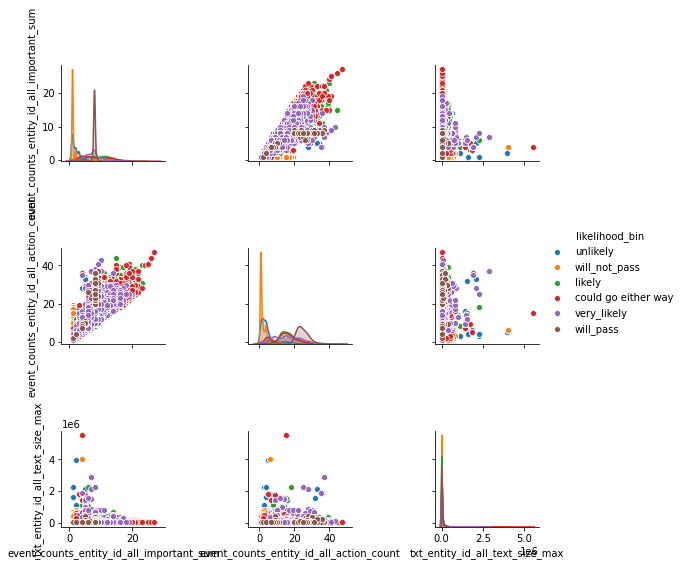

In [332]:
t_list = features_we_are_interested_in + ['likelihood_bin']
sns.pairplot(data=test_matrix[t_list], hue='likelihood_bin')

### Analysing each as_of_date

In [333]:
q = """
    select 
        to_char(as_of_date, 'YYYY-MM-DD') as as_of_date, count(*) as num_records, sum(label_value) as num_ones
    from test_results.predictions where model_id={}
    group by as_of_date
    order by as_of_date 
""".format(model_id)

as_of_date_stats = pd.read_sql(q, db_conn)

**Cohort size**

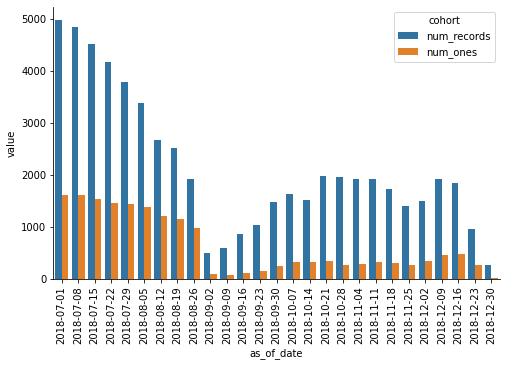

In [334]:
fig, ax = plt.subplots(figsize=(8,5))
df_t = as_of_date_stats[['as_of_date', 'num_records', 'num_ones']].melt('as_of_date', var_name='cohort',  value_name='value')
g = sns.barplot(data=df_t, x='as_of_date', y='value', hue='cohort')
t = g.set_xticklabels(labels=as_of_date_stats['as_of_date'], rotation=90)
sns.despine()

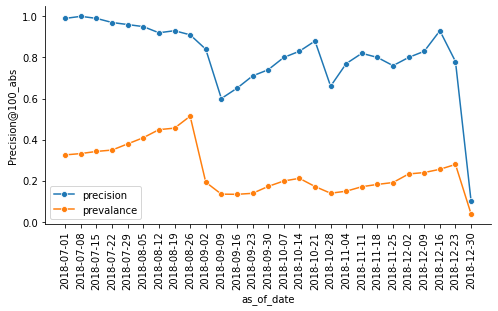

In [336]:
def precision_abs_asofdate(df, threshold=100):
    df = df.sort_values('score', ascending=False)
    
    num_ones = df['label_value'].iloc[:threshold].sum()
    
    d = dict()
    d['precision'] = float(num_ones/threshold)
    d['prevalance'] = float(df['label_value'].sum() / df.shape[0])
    
    return pd.Series(d)

threshold_abs = 100
t = model_predictions.groupby('as_of_date').apply(precision_abs_asofdate, threshold_abs).reset_index()

fig, ax = plt.subplots(figsize=(8,4))
g = sns.lineplot(data=t, x='as_of_date', y='precision', marker='o', label='precision')
sns.lineplot(data=t, x='as_of_date', y='prevalance', marker='o', label='prevalance')

t = g.set_xticklabels(labels=as_of_date_stats['as_of_date'], rotation=90)
ax.set_ylabel('Precision@{}_abs'.format(threshold_abs))
sns.despine()

#### Comparing lists

We consider each bucket as a list and compare overlap within that

In [366]:
q = """
    with models_in_460 as (
        select 
            model_id, train_end_time
        from triage_metadata.experiment_models join triage_metadata.models using(model_hash)
        where experiment_hash='f08d1c3b0dc1e385cc88f59a28c44b30'
        order by train_end_time
    ),
    models_in_375 as (
        select 
            model_id, train_end_time 
        from triage_metadata.experiment_models join triage_metadata.models using(model_hash)
        where experiment_hash='aa36a41222408534233ebd20b7adca54'
        order by train_end_time
    )
    select
        a.model_id as model_460,
        b.model_id as model_375,
        train_end_time
    from models_in_460 a join models_in_375 b using(train_end_time)
"""

model_ids_in_two_groups = pd.read_sql(q, db_conn)
model_ids_in_two_groups

,model_460,model_375,train_end_time
0,11759,11772,2012-07-01
1,11760,11773,2013-01-01
2,11761,11774,2013-07-01
3,11762,11775,2014-01-01
4,11763,11776,2014-07-01
5,11764,11777,2015-01-01
6,11765,11778,2015-07-01
7,11766,11779,2016-01-01
8,11767,11780,2016-07-01
9,11768,11781,2017-01-01


In [384]:
union_q = """
    select distinct entity_id from test_results.predictions 
    where model_id={model_id_g1} and score >= {thresh_lower} and score < {thresh_upper}
	UNION
	select distinct entity_id from test_results.predictions 
    where model_id={model_id_g2} and score >= {thresh_lower} and score < {thresh_upper}
"""

intersection_q = """
    select distinct entity_id from test_results.predictions 
    where model_id={model_id_g1} and score >= {thresh_lower} and score < {thresh_upper}
	INTERSECT
	select distinct entity_id from test_results.predictions 
    where model_id={model_id_g2} and score >= {thresh_lower} and score < {thresh_upper}
"""

In [394]:
def calc_iou(row, likelihood_bins):
    for bin_name, lims in likelihood_bins.items(): 
        q = union_q.format(
            model_id_g1=row['model_375'],
            model_id_g2=row['model_460'],
            thresh_lower=lims[0],
            thresh_upper=lims[1]
        )
        un = pd.read_sql(q, db_conn)

        q = intersection_q.format(
            model_id_g1=row['model_375'],
            model_id_g2=row['model_460'],
            thresh_lower=lims[0],
            thresh_upper=lims[1]
        )
        inter = pd.read_sql(q, db_conn)

        if len(un) == 0:
            row['iou_{}'.format(bin_name)] = None
        else:
            row['iou_{}'.format(bin_name)] = len(inter) / len(un) 
    
    return row

In [395]:
ious = model_ids_in_two_groups.apply(calc_iou, likelihood_bins=buckets, axis=1)

In [398]:
ious

,model_460,model_375,train_end_time,iou_will_not_pass,iou_unlikely,iou_could go either way,iou_likely,iou_very_likely,iou_will_pass
0,11759,11772,2012-07-01,0.936414,0.972514,0.963706,0.939138,0.904215,NaN
1,11760,11773,2013-01-01,0.951475,0.972427,0.936297,0.932980,0.894998,0.900498
2,11761,11774,2013-07-01,0.938177,0.954325,0.888942,0.903150,0.947368,0.581818
3,11762,11775,2014-01-01,0.954313,0.962148,0.921813,0.933559,0.899676,0.806993
4,11763,11776,2014-07-01,0.943051,0.911164,0.949574,0.947865,0.935449,0.970588
5,11764,11777,2015-01-01,0.962465,0.944070,0.935129,0.929005,0.945001,0.877003
6,11765,11778,2015-07-01,0.950289,0.938125,0.918422,0.949904,0.932363,0.875000
7,11766,11779,2016-01-01,0.964084,0.970471,0.926503,0.919092,0.942186,0.853199
8,11767,11780,2016-07-01,0.955081,0.914751,0.952148,0.954724,0.939590,0.889362
9,11768,11781,2017-01-01,0.959984,0.957962,0.917915,0.914392,0.934554,0.717210


Text(0, 0.5, 'iou values')

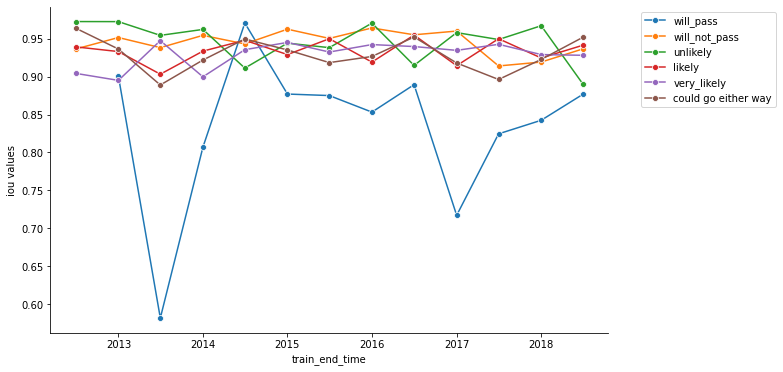

In [405]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=ious, x='train_end_time', y='iou_will_pass', marker='o', label='will_pass')
sns.lineplot(data=ious, x='train_end_time', y='iou_will_not_pass', marker='o', label='will_not_pass')
sns.lineplot(data=ious, x='train_end_time', y='iou_unlikely', marker='o', label='unlikely')
sns.lineplot(data=ious, x='train_end_time', y='iou_likely', marker='o', label='likely')
sns.lineplot(data=ious, x='train_end_time', y='iou_very_likely', marker='o', label='very_likely')
sns.lineplot(data=ious, x='train_end_time', y='iou_could go either way', marker='o', label='could go either way')
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1))
ax.set_ylabel('iou values')